# DATA LEAKAGE 조심!! 또 확인!!

***

# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import random
import time
import os

import datetime

import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 13

# Fixed Random Seed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# Load Dataset

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train.head(5)

,ID,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),풍속 (m/s)
0,TRAIN_00000,7,2,저녁,13.97,287.78,9.84,76.1,992.08,15.98,12.16,3.82,7.66,1198.06,155.60,1.61
1,TRAIN_00001,8,21,오전,16.94,290.85,12.14,73.3,991.07,19.33,14.17,5.16,8.94,1183.67,177.00,1.68
2,TRAIN_00002,11,1,저녁,9.76,283.84,5.40,74.2,988.71,12.10,8.98,3.12,5.67,1213.22,146.20,0.73
3,TRAIN_00003,12,28,오전,5.27,277.30,2.71,83.5,1014.25,8.89,7.43,1.47,4.57,1265.48,264.50,2.71
4,TRAIN_00004,9,26,오후,17.35,290.86,12.68,74.0,995.77,19.84,14.68,5.16,9.22,1187.40,19.34,1.00


In [5]:
test.head(5)

,ID,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg)
0,TEST_00000,3,24,새벽,4.28,278.68,-0.21,72.5,984.48,8.30,6.02,2.28,3.81,1233.29,251.80
1,TEST_00001,9,24,저녁,13.40,286.81,10.36,81.8,996.98,15.40,12.59,2.80,7.89,1206.20,225.60
2,TEST_00002,5,28,저녁,19.89,294.33,14.95,73.2,984.83,23.26,17.03,6.23,10.82,1163.06,10.39
3,TEST_00003,1,17,저녁,-2.88,270.44,-4.47,88.7,998.02,4.94,4.38,0.56,2.73,1284.19,260.20
4,TEST_00004,10,22,오후,6.97,281.18,4.36,83.4,987.00,10.01,8.35,1.66,5.28,1223.47,262.50


# At a glance

Dataset Info.

#### train.csv
57920개의 데이터  
ID : 샘플 별 고유 id  
월: 데이터가 기록된 달을 나타냅니다.  
일: 데이터가 기록된 날짜를 나타냅니다.  
측정 시간대: 데이터가 측정된 시간대를 나타냅니다. 오전, 오후, 저녁, 새벽으로 구분되어 있습니다.  
섭씨 온도 (° ⁣C)  
절대 온도 (K)  
이슬점 온도 (° ⁣C)  
상대 습도 (%)  
대기압 (mbar)  
포화 증기압 (mbar)  
실제 증기압 (mbar)  
증기압 부족량 (mbar)  
수증기 함량 (g/kg): 공기 1 kg당 수증기의 질량을 그램(g) 단위로 나타냅니다.  
공기 밀도 (g/m**3): 1 m³의 부피에 들어있는 공기의 질량을 그램(g) 단위로 나타냅니다.  
풍향 (deg): 바람의 향하는 방향을 각도(degree)로 나타냅니다.  
풍속 (m/s)

train 데이터프레임은 총 26129개의 행(RangeIndex)과 16개의 열(Data columns)로 구성되어 있습니다.

수치형 데이터가 12개(float64)와 2개(int64)의 컬럼으로 구성되어 있으며, object 타입의 컬럼도 2개 있습니다.
따라서 'ID'와 '측정 시간대' 컬럼이 문자열 데이터라는 것을 알 수 있습니다.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36581 entries, 0 to 36580
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              36581 non-null  object 
 1   월               36581 non-null  int64  
 2   일               36581 non-null  int64  
 3   측정 시간대          36581 non-null  object 
 4   섭씨 온도(°⁣C)      36581 non-null  float64
 5   절대 온도(K)        36581 non-null  float64
 6   이슬점 온도(°C)      36581 non-null  float64
 7   상대 습도 (%)       36581 non-null  float64
 8   대기압(mbar)       36581 non-null  float64
 9   포화 증기압(mbar)    36581 non-null  float64
 10  실제 증기압(mbar)    36581 non-null  float64
 11  증기압 부족량(mbar)   36581 non-null  float64
 12  수증기 함량 (g/kg)   36581 non-null  float64
 13  공기 밀도 (g/m**3)  36581 non-null  float64
 14  풍향 (deg)        36581 non-null  float64
 15  풍속 (m/s)        36581 non-null  float64
dtypes: float64(12), int64(2), object(2)
memory usage: 4.5+ MB


# Background Knowledge

#### 풍속과 관련 있는 변수

1. 대기압 (mbar): 기압은 대기의 무게로 인해 발생하므로, 대기압은 기압에 직접적인 영향을 미칩니다.

2. 이슬점 온도 (° ⁣C): 이슬점 온도는 공기가 포화 상태로 수증기를 포함하는데 필요한 온도를 의미하며, 공기가 포화되면 대기압에 영향을 줄 수 있습니다.

3. 상대 습도 (%): 상대 습도는 공기가 포화 상태에 얼마나 가까운지를 나타내는데, 수증기가 포화되면 기압에 영향을 미칠 수 있습니다.

4. 수증기 함량 (g/kg): 공기 내의 수증기의 양은 대기압과 관련하여 영향을 미칠 수 있습니다.

5. 섭씨 온도 (° ⁣C) 또는 절대 온도 (K): 온도의 변화는 대기의 열적 팽창과 함께 기압에 영향을 미칠 수 있습니다.

6. 증기압 부족량 (mbar): 공기 중의 수증기가 포화 상태에 미치지 못하는 압력 차이로, 기압에 영향을 줄 수 있습니다.

7. 공기 밀도 (g/m**3): 공기의 밀도는 공기의 질량과 부피에 영향을 미치며, 이는 일부 경우에 기압에 영향을 미칠 수 있습니다.

8. 측정 시간대: 측정 시간대는 기압에 직접적인 영향은 없지만, 기상 조건과 관련하여 다른 변수들과 함께 영향을 미칠 수 있습니다.

풍향 (deg)은 바람의 방향을 나타내기 때문에 기압에 직접적인 영향을 미치지 않지만, 바람은 기압의 차이로 인해 발생하고 이동하므로 간접적으로 기압과 연관이 있습니다. 따라서 바람은 기압 변화와 관련하여 중요한 요소입니다. 하지만 바람의 방향 자체가 기압에 직접적인 영향을 주지는 않습니다.

#### 풍속과 관련 적은 변수
1. 섭씨 온도 (° ⁣C) 또는 절대 온도 (K): 풍속은 주로 기압 차이에 의해 발생하고, 온도는 풍속에 직접적인 영향을 주지 않습니다. 따라서 풍속을 결정하는데 온도는 크게 영향을 미치지 않습니다.

2. 증기압 부족량 (mbar): 증기압 부족량은 공기 중의 수증기가 포화 상태에 미치지 못하는 압력 차이를 나타냅니다. 풍속을 결정하는데 이 변수는 직접적인 영향을 주지 않습니다.

3. 공기 밀도 (g/m**3): 풍속은 대기의 움직임과 기압 차이에 의해 발생하고, 공기의 밀도는 풍속에 큰 영향을 미치지 않습니다.

4. 측정 시간대: 풍속은 대기의 움직임과 기압 차이에 따라 형성되므로, 측정 시간대는 풍속에 직접적인 영향을 주지 않습니다.

위 변수들은 풍속에 직접적인 영향을 미치지 않는다는 것을 기억하는 것이 중요합니다. 풍속은 주로 기압 차이에 의해 발생하며, 바람은 기압이 낮은 곳에서 기압이 높은 곳으로 흐르는 경향을 가지기 때문에 기압과 관련된 변수들이 풍속에 큰 영향을 미칩니다. 따라서 풍속을 예측하거나 이해하기 위해서는 주로 기압과 관련된 변수들이 중요하며, 기온, 증기압, 공기 밀도, 측정 시간대는 풍속과의 직접적인 관련성이 낮습니다.

# Data Split

모델을 학습하기 위해서는 독립변수(X)와 종속변수(y)로 나누어야 합니다.  
독립변수는 Feature, 종속변수는 Target이라고 불리기도 합니다.  

Feature : 예측을 위해 활용되는 데이터  
Target : 예측하고자 하는 대상  
(이 때, 분석에 활용하지 않는 데이터인 'id'는 제거하겠습니다.)

In [7]:
# train_x는 독립변수이므로 종속변수(풍속 (m/s))를 제거합니다. 
# 또한 target 이외의 분석에 활용하지 않는 데이터(id)를 제거합니다.
train_x = train.drop(columns=['ID', '풍속 (m/s)'], axis = 1)

# train_y는 종속변수로 값을 설정합니다.
train_y = train['풍속 (m/s)']

In [8]:
# train에서와 마찬가지로 분석에 활용하지 않는 데이터(id)를 제거합니다.
test_x = test.drop(columns=['ID'])

# Data Pre-processing

### LabelEncoder

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le = le.fit(train_x['측정 시간대'])
train_x['측정 시간대'] = le.transform(train_x['측정 시간대'])
test_x['측정 시간대'] = le.transform(test_x['측정 시간대'])

# Explore Datset

## 상관관계 분석 및 다중공선성 분석

In [13]:
# 상관관계 분석
correlation_matrix = train_x.corr()

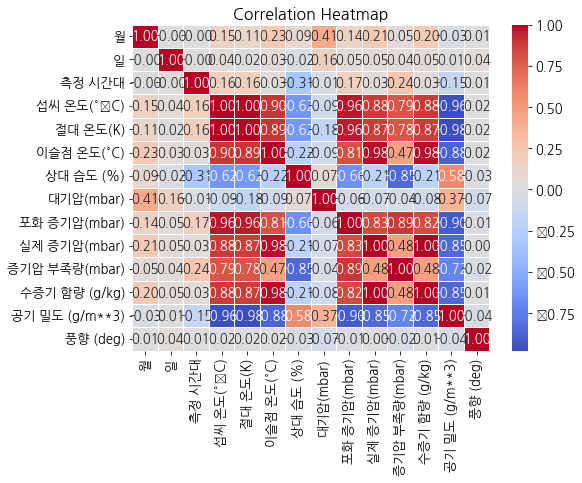

In [14]:
plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)

plt.show()

In [24]:
# VIF 계산
vif = pd.DataFrame()
vif["Variables"] = train_x.columns
vif["VIF"] = [variance_inflation_factor(train_x.values, i) for i in range(train_x.shape[1])]

vif

# 일반적으로 VIF 값이 5 이상인 변수는 다중공선성의 문제가 있을 수 있으며, VIF 값이 10 이상이면 심각한 다중공선성이 발생하는 것으로 간주됩니다.

,Variables,VIF
0,월,6.448969e+00
1,일,4.391479e+00
2,측정 시간대,3.147721e+00
3,섭씨 온도(°⁣C),4.732687e+04
4,절대 온도(K),7.434047e+04
5,이슬점 온도(°C),9.456704e+02
6,상대 습도 (%),1.699479e+03
7,대기압(mbar),2.192487e+07
8,포화 증기압(mbar),1.043693e+07
9,실제 증기압(mbar),4.592867e+06


### Column Drop

중요도순

풍향, 대기압, 일, 섭씨 온도, 이슬점 온도, 상대 습도, 월, 공기 밀도, 증기압 부족량, 측정 시간대, 절대 온도, 수증기 함량, 실제 증기압, 포화 증기압

In [25]:
train_x = train_x.drop(['실제 증기압(mbar)', '포화 증기압(mbar)', '이슬점 온도(°C)', '절대 온도(K)'], axis=1)

In [26]:
test_x = test_x.drop(['실제 증기압(mbar)', '포화 증기압(mbar)', '이슬점 온도(°C)', '절대 온도(K)'], axis=1)

In [ ]:
train_x

# Model Definition

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# dt_clf = DecisionTreeRegressor(random_state=11) 

In [27]:
# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, shuffle=True, random_state=42)

In [28]:
xgb_model = XGBRegressor(random_state=42)

# Hyperparameter Tuning

In [29]:
# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [130, 150, 170],       # 트리의 개수
    'max_depth': [6, 7, 8],               # 트리의 최대 깊이
    'learning_rate': [0.08, 0.1, 0.12],  # 학습률
}

In [30]:
# Grid Search 시작 시간 기록
start_time = time.time()

# GridSearchCV를 사용하여 모델 튜닝
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Grid Search 종료 시간 기록
end_time = time.time()

# 걸린 시간 계산
elapsed_time = end_time - start_time
print("Grid Search elapsed time: {:.2f} seconds".format(elapsed_time))

Grid Search elapsed time: 453.03 seconds


In [31]:
# 최적의 하이퍼파라미터와 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE found: {:.4f}".format(np.sqrt(-grid_search.best_score_)))

Best parameters found:  {'learning_rate': 0.12, 'max_depth': 8, 'n_estimators': 170}
Best RMSE found: nan


# Model Fit

In [32]:
# dt_clf.fit(train_x , train_y) 

In [33]:
# xgb_model.fit(train_x, train_y)
# xgboost.plot_importance(xgb_model)

In [34]:
# 최적의 하이퍼파라미터로 모델 생성 및 훈련
best_xgb_model = XGBRegressor(**grid_search.best_params_)
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.12, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=170, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
# Split한 테스트 데이터에 대한 예측 수행
y_pred = best_xgb_model.predict(X_test)

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print("MAE: {:.4f}".format(mae))

MAE: 0.5029


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

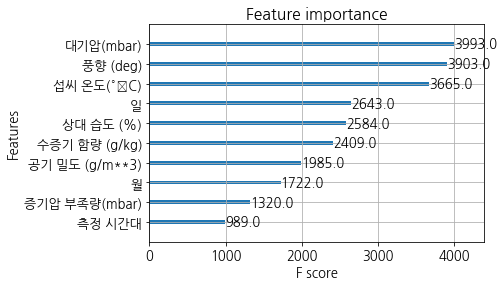

In [36]:
xgboost.plot_importance(best_xgb_model)

# Prediction

In [37]:
# dt_pred = dt_clf.predict(test_x) 

In [38]:
# 테스트 데이터로 예측
xgb_pred = best_xgb_model.predict(test_x)

# Submit

In [39]:
submission = pd.read_csv('./data/sample_submission.csv')

In [40]:
submission['풍속 (m/s)'] = xgb_pred
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,2.109473
1,TEST_00001,0.974883
2,TEST_00002,1.678261
3,TEST_00003,1.347461
4,TEST_00004,1.441243


In [41]:
submission.to_csv('submission/submission_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'.csv', index=  False)

//끝//